In [252]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import statsmodels.api as sm

from datetime import datetime

### Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [253]:
# считываем датасет
data = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year'])
data.head() 

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

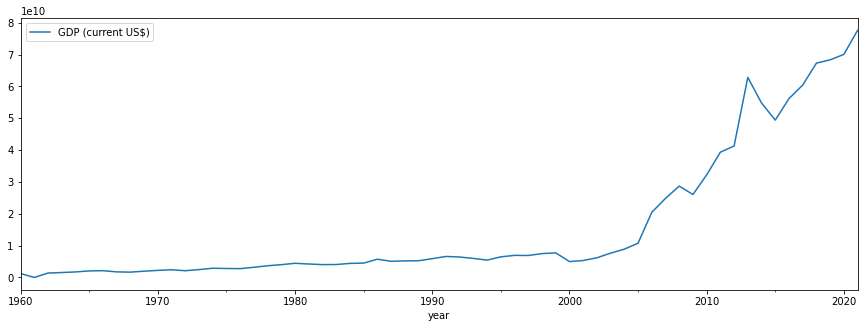

In [276]:
# визуализируем исходный временной ряд
plt.rcParams["figure.figsize"] = 15, 5
data.plot()

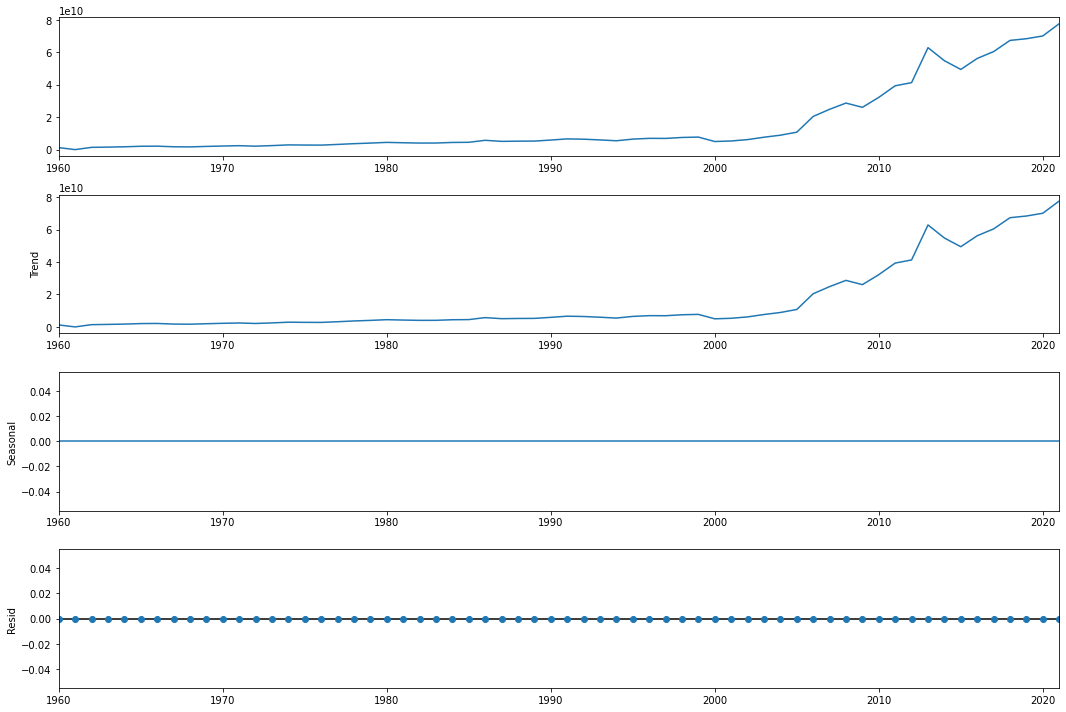

In [255]:
plt.rcParams["figure.figsize"] = 15, 10

result = seasonal_decompose(data)
result.plot()
plt.show()

*Вывод: В наличии тренд (рост), сезонность и шум отсутствуют, так как выборка небольшая и редкая (одно значение в год).

In [277]:
# Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-4:-1]
train_df = data.iloc[:-4]

### 2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. 

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

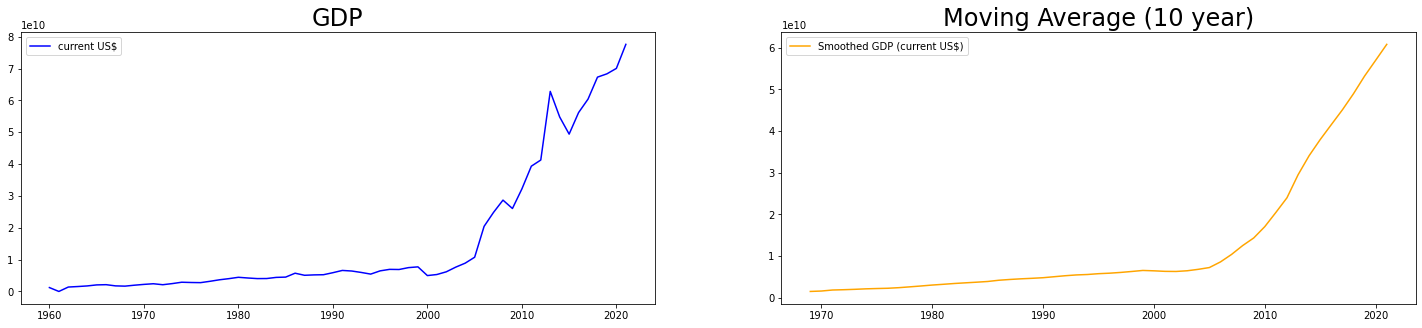

In [281]:
plt.rcParams["figure.figsize"] = 25, 5

fig, ax = plt.subplots(1, 2)

# Окно выбираем в декаду (Window = 10)
ax[0].plot(data, color="blue", label="current US$")
ax[0].set_title("GDP", size=24)
ax[0].legend()

ax[1].plot(
    data.rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1].set_title("Moving Average (10 year)", size=24)
ax[1].legend()

plt.show()

*/ Вывод: Сглаживание позволяет более наглядно выделить общий тренд /*

### 3. С помощью теста Дики-Фуллера оценить стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. 

In [258]:
from statsmodels.tsa.stattools import adfuller

In [259]:
# задаем функцию проверки на стационарность ряда и проверяем исходный ряд
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.5393306248349177
p-value:  0.9860207453998459
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


*/ Вывод: Ряд нестационарен, необходимо применить дифференцирование /*

In [260]:
# дифференцируем ряд и проверяем на стационарность
data_diff = train_df.diff().dropna()
stat_test(data_diff)

adf:  -0.7957779955549791
p-value:  0.8203591046306415
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [261]:
# ещё раз дифференцируем ряд и проверяем на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -2.6938797070150144
p-value:  0.07510334813233245
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [262]:
# третий раз дифференцируем ряд и проверяем на стационарность
data_diff = data_diff.diff().dropna()
stat_test(data_diff)

adf:  -13.428793452586433
p-value:  4.0521041077229072e-25
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


*/ Вывод: исходный временной ряд является интегрированным рядом 3-го порядка. Необходимо использовать модель ARIMA /*

In [263]:
d=3

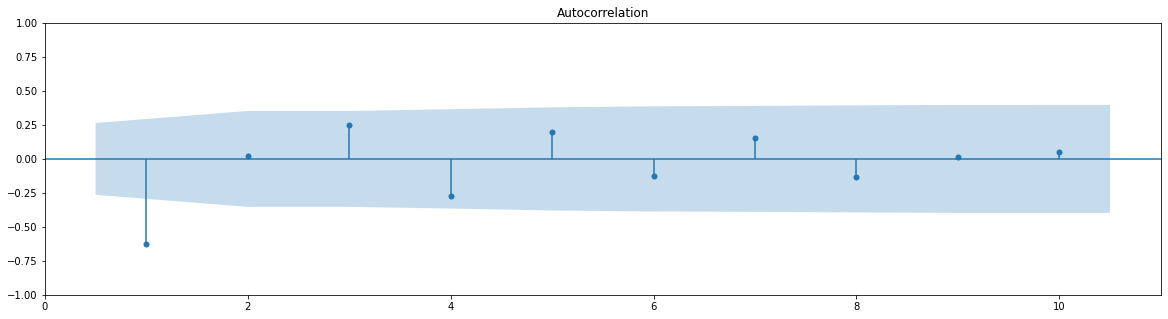

In [264]:
# Параметры p и q определяем по коррелограммам ACF и PACF
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(data_diff, lags=10, zero=False)
plt.show()

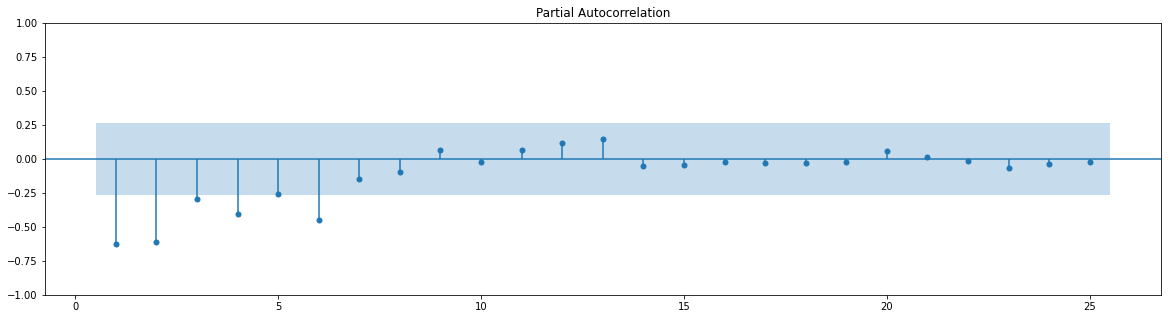

In [265]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(data_diff, lags=25, zero=False, method="ywm")
plt.show()

In [266]:
q=1
p=2

### Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

In [282]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   58
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1301.212
Date:                Wed, 06 Sep 2023   AIC                           2610.423
Time:                        17:34:31   BIC                           2618.453
Sample:                    01-01-1960   HQIC                          2613.528
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7622      0.129     -5.905      0.000      -1.015      -0.509
ar.L2         -0.5164      0.240     -2.149      0.032      -0.987      -0.045
ma.L1         -0.9743      0.106     -9.193      0.000      -1.182      -0.767
sigma2      3.044e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               175.50
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):             407.41   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.7e+55. Standard errors may be unstable.
"""

In [283]:
# выбираем наилучшие параметры с помощью пакета pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2619.511, Time=0.26 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2686.859, Time=0.03 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2659.570, Time=0.05 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2610.423, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2631.764, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2610.925, Time=0.10 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2627.500, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2612.413, Time=0.19 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.629 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1301.212
Date:                Wed, 06 Sep 2023   AIC                           2610.423
Time:                        18:01:27   BIC                           2618.453
Sample:                    01-01-1960   HQIC                          2613.528
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7622      0.129     -5.905      0.000      -1.015      -0.509
ar.L2         -0.5164      0.240     -2.149      0.032      -0.987      -0.045
ma.L1         -0.9743      0.106     -9.193      0.000      -1.182      -0.767
sigma2      3.044e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               175.50
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):             407.41   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.7e+55. Standard errors may be unstable.
"""

*/ Вывод: перебор по сетке методом pmdarima показал, что параметры выбраны верно /*

### Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [286]:
# обучаем модель ARIMA и делаем предсказание для последних трёх позиций
arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()

ar_pred = arima_model_fit.predict(start=len(train_df), end=(len(train_df)+2), dynamic=False)
ar_pred

d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
d:\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


2018-01-01    6.041828e+10
2019-01-01    6.507265e+10
2020-01-01    6.849186e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [308]:
# заглянем на 10 лет в будущее
ar_pred = arima_model_fit.predict(start=60, end=70, dynamic=False)
ar_pred

2020-01-01    6.849186e+10
2021-01-01    7.057388e+10
2022-01-01    7.443190e+10
2023-01-01    7.774588e+10
2024-01-01    8.067627e+10
2025-01-01    8.429896e+10
2026-01-01    8.771107e+10
2027-01-01    9.104512e+10
2028-01-01    9.466638e+10
2029-01-01    9.822803e+10
2030-01-01    1.018058e+11
Freq: AS-JAN, Name: predicted_mean, dtype: float64

### Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [309]:
# собираем в датасет данные для визуализации
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

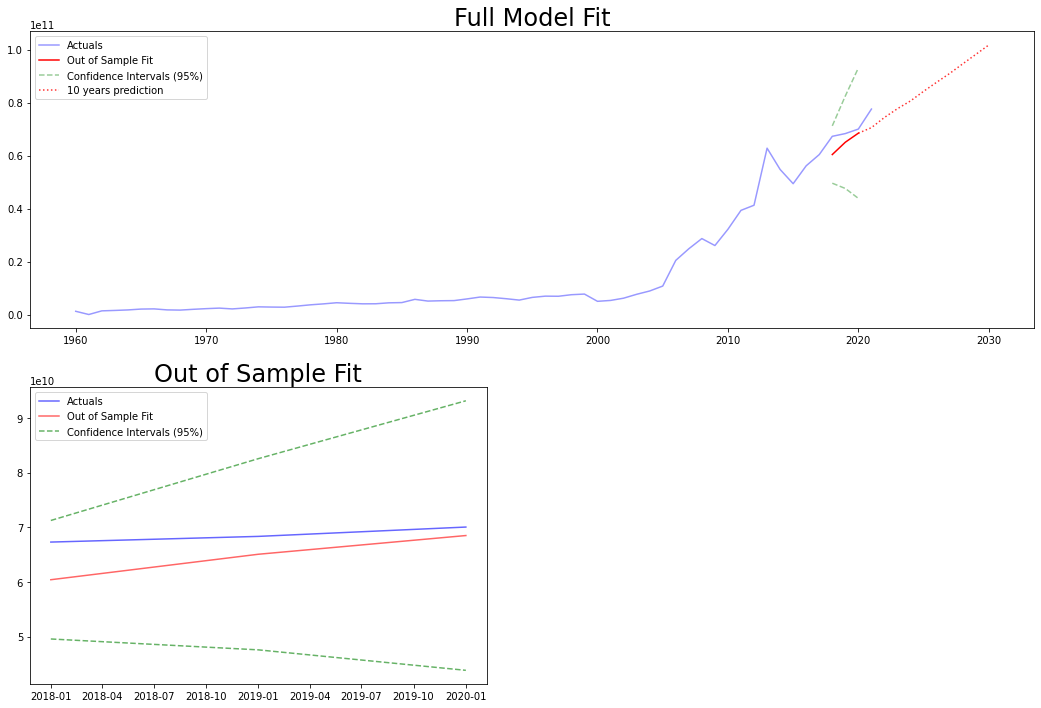

In [310]:
# строим графики истинного и предсказанного поведения временного ряда
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.plot(
    ar_pred,
    color="red",
    linestyle='dotted',
    alpha=0.8,
    label="10 years prediction",
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

*/ Вывод: модель уловила общий тренд. Предсказания близки к актуальным данным /*